<a href="https://colab.research.google.com/github/andrewmarion/MarchMadness/blob/main/FinalProjectMarchMadness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# March Madness
## Final Project
### Group 15: Andrew Marion, Dallas Hutchinson, Aydan Koyles


# Setting Up File

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Imports

In [6]:
import json
from pyspark.mllib.classification import LogisticRegressionModel,LogisticRegressionWithLBFGS, SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.mllib.clustering import *
import pyspark.sql
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import LDA
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql.functions import lit

# Read in csv file

In [7]:
RegularSeason = spark.read.option("header",True).csv("/content/gdrive/MyDrive/MDataFiles_Stage2/MRegularSeasonDetailedResults.csv", inferSchema = True)
Seeds = spark.read.option("header",True).csv("/content/gdrive/MyDrive/MDataFiles_Stage2/MNCAATourneySeeds.csv", inferSchema = True)
Tourney = spark.read.option("header",True).csv("/content/gdrive/MyDrive/MDataFiles_Stage2/MNCAATourneyDetailedResults.csv", inferSchema = True)
Conferences = spark.read.option("header",True).csv("/content/gdrive/MyDrive/MDataFiles_Stage2/MNCAATourneySeeds.csv", inferSchema = True)
Coaches = spark.read.option("header",True).csv("/content/gdrive/MyDrive/MDataFiles_Stage2/MTeamCoaches.csv", inferSchema = True)
TourneyCompact = spark.read.option("header",True).csv("/content/gdrive/MyDrive/MDataFiles_Stage2/MNCAATourneyCompactResults.csv", inferSchema = True)
Teams = spark.read.option("header",True).csv("/content/gdrive/MyDrive/MDataFiles_Stage2/MTeams.csv", inferSchema = True)

# Clean / Explore Data

## Season Input

In [8]:
WinTeams = RegularSeason.groupBy('Season', 'WTeamID').sum('WScore','LScore','NumOT','WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF','LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF')
LoseTeams = RegularSeason.groupBy('Season', 'LTeamID').sum('WScore','LScore','NumOT','WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF','LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF')

In [9]:
NumWin = RegularSeason.groupBy('Season', 'WTeamID').count()
NumWin = NumWin.withColumnRenamed("count", "Wins")
NumWin = NumWin.withColumnRenamed("WTeamID", "TeamID")

NumLose = RegularSeason.groupBy('Season', 'LTeamID').count()
NumLose = NumLose.withColumnRenamed("count", "Loses")
NumLose = NumLose.withColumnRenamed("LTeamID", "TeamID")

merged_df = NumWin.join(NumLose, ['Season','TeamID'])
merged_df = merged_df.withColumn('NumGames', merged_df.Wins + merged_df.Loses)

In [10]:
# Get all win stats for each team
WinTeams = WinTeams.withColumnRenamed("WTeamID", "TeamID")
WinTeams = WinTeams.withColumnRenamed("sum(WScore)", "WPTS")
WinTeams = WinTeams.withColumnRenamed("sum(LScore)", "WOppPTS")
WinTeams = WinTeams.withColumnRenamed("sum(NumOT)", "WOTs")
WinTeams = WinTeams.withColumnRenamed("sum(WFGM)", "WFGM")
WinTeams = WinTeams.withColumnRenamed("sum(WFGA)", "WFGA")
WinTeams = WinTeams.withColumnRenamed("sum(WFGA3)", "WFGA3")
WinTeams = WinTeams.withColumnRenamed("sum(WFGM3)", "WFGM3")
WinTeams = WinTeams.withColumnRenamed("sum(WFTA)", "WFTA")
WinTeams = WinTeams.withColumnRenamed("sum(WFTM)", "WFTM")
WinTeams = WinTeams.withColumnRenamed("sum(WOR)", "WOR")
WinTeams = WinTeams.withColumnRenamed("sum(WDR)", "WDR")
WinTeams = WinTeams.withColumnRenamed("sum(WAst)", "WAST")
WinTeams = WinTeams.withColumnRenamed("sum(WTO)", "WTO")
WinTeams = WinTeams.withColumnRenamed("sum(WStl)", "WSTL")
WinTeams = WinTeams.withColumnRenamed("sum(WBlk)", "WBLK")
WinTeams = WinTeams.withColumnRenamed("sum(WPF)", "WPF")
WinTeams = WinTeams.withColumnRenamed("sum(LFGM)", "WOppFGM")
WinTeams = WinTeams.withColumnRenamed("sum(LFGA)", "WOppFGA")
WinTeams = WinTeams.withColumnRenamed("sum(LFGA3)", "WOppFGA3")
WinTeams = WinTeams.withColumnRenamed("sum(LFGM3)", "WOppFGM3")
WinTeams = WinTeams.withColumnRenamed("sum(LFTA)", "WOppFTA")
WinTeams = WinTeams.withColumnRenamed("sum(LFTM)", "WOppFTM")
WinTeams = WinTeams.withColumnRenamed("sum(LOR)", "WOppOR")
WinTeams = WinTeams.withColumnRenamed("sum(LDR)", "WOppDR")
WinTeams = WinTeams.withColumnRenamed("sum(LAst)", "WOppAST")
WinTeams = WinTeams.withColumnRenamed("sum(LTO)", "WOppTO")
WinTeams = WinTeams.withColumnRenamed("sum(LStl)", "WOppSTL")
WinTeams = WinTeams.withColumnRenamed("sum(LBlk)", "WOppBLK")
WinTeams = WinTeams.withColumnRenamed("sum(LPF)", "WOppPF")

In [11]:
# Get all loss stats for each team
LoseTeams = LoseTeams.withColumnRenamed("LTeamID", "TeamID")
LoseTeams = LoseTeams.withColumnRenamed("sum(WScore)", "LOppPTS")
LoseTeams = LoseTeams.withColumnRenamed("sum(LScore)", "LPTS")
LoseTeams = LoseTeams.withColumnRenamed("sum(NumOT)", "LOTs")
LoseTeams = LoseTeams.withColumnRenamed("sum(WFGM)", "LOppFGM")
LoseTeams = LoseTeams.withColumnRenamed("sum(WFGA)", "LOppFGA")
LoseTeams = LoseTeams.withColumnRenamed("sum(WFGA3)", "LOppFGA3")
LoseTeams = LoseTeams.withColumnRenamed("sum(WFGM3)", "LOppFGM3")
LoseTeams = LoseTeams.withColumnRenamed("sum(WFTA)", "LOppFTA")
LoseTeams = LoseTeams.withColumnRenamed("sum(WFTM)", "LOppFTM")
LoseTeams = LoseTeams.withColumnRenamed("sum(WOR)", "LOppOR")
LoseTeams = LoseTeams.withColumnRenamed("sum(WDR)", "LOppDR")
LoseTeams = LoseTeams.withColumnRenamed("sum(WAst)", "LOppAST")
LoseTeams = LoseTeams.withColumnRenamed("sum(WTO)", "LOppTO")
LoseTeams = LoseTeams.withColumnRenamed("sum(WStl)", "LOppSTL")
LoseTeams = LoseTeams.withColumnRenamed("sum(WBlk)", "LOppBLK")
LoseTeams = LoseTeams.withColumnRenamed("sum(WPF)", "LOppPF")
LoseTeams = LoseTeams.withColumnRenamed("sum(LFGM)", "LFGM")
LoseTeams = LoseTeams.withColumnRenamed("sum(LFGA)", "LFGA")
LoseTeams = LoseTeams.withColumnRenamed("sum(LFGA3)", "LFGA3")
LoseTeams = LoseTeams.withColumnRenamed("sum(LFGM3)", "LFGM3")
LoseTeams = LoseTeams.withColumnRenamed("sum(LFTA)", "LFTA")
LoseTeams = LoseTeams.withColumnRenamed("sum(LFTM)", "LFTM")
LoseTeams = LoseTeams.withColumnRenamed("sum(LOR)", "LOR")
LoseTeams = LoseTeams.withColumnRenamed("sum(LDR)", "LDR")
LoseTeams = LoseTeams.withColumnRenamed("sum(LAst)", "LAST")
LoseTeams = LoseTeams.withColumnRenamed("sum(LTO)", "LTO")
LoseTeams = LoseTeams.withColumnRenamed("sum(LStl)", "LSTL")
LoseTeams = LoseTeams.withColumnRenamed("sum(LBlk)", "LBLK")
LoseTeams = LoseTeams.withColumnRenamed("sum(LPF)", "LPF")

In [12]:
LoseTeams.filter(LoseTeams.Season == 2022).show()

+------+------+-------+----+----+-------+-------+--------+--------+-------+-------+------+------+-------+------+-------+-------+------+----+----+-----+-----+----+----+---+---+----+---+----+----+---+
|Season|TeamID|LOppPTS|LPTS|LOTs|LOppFGM|LOppFGA|LOppFGM3|LOppFGA3|LOppFTM|LOppFTA|LOppOR|LOppDR|LOppAST|LOppTO|LOppSTL|LOppBLK|LOppPF|LFGM|LFGA|LFGM3|LFGA3|LFTM|LFTA|LOR|LDR|LAST|LTO|LSTL|LBLK|LPF|
+------+------+-------+----+----+-------+-------+--------+--------+-------+-------+------+------+-------+------+-------+-------+------+----+----+-----+-----+----+----+---+---+----+---+----+----+---+
|  2022|  1175|   1896|1515|   1|    643|   1500|     248|     687|    362|    513|   273|   607|    411|   335|    210|     90|   451| 538|1355|  143|  444| 296| 439|190|552| 222|419| 166|  95|460|
|  2022|  1180|   1059| 958|   2|    399|    823|      94|     249|    167|    235|   101|   329|    166|   142|    111|     36|   213| 366| 837|   99|  308| 127| 176|123|314| 148|172|  56|  41|227|
|  20

In [13]:
# combine win teams and lose teams
Season = WinTeams.join(LoseTeams, ['Season','TeamID'])

In [14]:
# Combine columns
Season = Season.withColumn("OppPTS", Season.WOppPTS + Season.LOppPTS) 
Season = Season.withColumn("PTS", Season.WPTS + Season.LPTS) 
Season = Season.withColumn("OTs", Season.WOTs + Season.LOTs) 
Season = Season.withColumn("OppFGM", Season.WOppFGM + Season.LOppFGM)
Season = Season.withColumn("OppFGA", Season.WOppFGA + Season.LOppFGA)
Season = Season.withColumn("OppFGA3", Season.WOppFGA3 + Season.LOppFGA3)
Season = Season.withColumn("OppFGM3", Season.WOppFGM3 + Season.LOppFGM3) 
Season = Season.withColumn("OppFTA", Season.WOppFTA + Season.LOppFTA) 
Season = Season.withColumn("OppFTM", Season.WOppFTM + Season.LOppFTM) 
Season = Season.withColumn("OppOR", Season.WOppOR + Season.LOppOR) 
Season = Season.withColumn("OppDR", Season.WOppDR + Season.LOppDR) 
Season = Season.withColumn("OppAST", Season.WOppAST + Season.LOppAST) 
Season = Season.withColumn("OppTO", Season.WOppTO + Season.LOppTO) 
Season = Season.withColumn("OppSTL", Season.WOppSTL + Season.LOppSTL) 
Season = Season.withColumn("OppBLK", Season.WOppBLK + Season.LOppBLK) 
Season = Season.withColumn("OppPF", Season.WOppPF + Season.LOppPF) 
Season = Season.withColumn("FGM", Season.WFGM + Season.LFGM) 
Season = Season.withColumn("FGA", Season.WFGA + Season.LFGA) 
Season = Season.withColumn("FGA3", Season.WFGA3 + Season.LFGA3) 
Season = Season.withColumn("FGM3", Season.WFGM3 + Season.LFGM3) 
Season = Season.withColumn("FTA", Season.WFTA + Season.LFTA) 
Season = Season.withColumn("FTM", Season.WFTM + Season.LFTM) 
Season = Season.withColumn("OR", Season.WOR + Season.LOR) 
Season = Season.withColumn("DR", Season.WDR + Season.LDR) 
Season = Season.withColumn("AST", Season.WAST + Season.LAST)
Season = Season.withColumn("TO", Season.WTO + Season.LTO) 
Season = Season.withColumn("STL", Season.WSTL + Season.LSTL)
Season = Season.withColumn("BLK", Season.WBLK + Season.LBLK)
Season = Season.withColumn("PF", Season.WPF + Season.LPF)

# Drop Unwanted Columns
Season =  Season.drop("WPTS","WOppPTS","WOTs","WFGM","WFGA","WFGM3","WFGA3","WFTM","WFTA","WOR","WDR","WAST","WTO","WSTL","WBLK","WPF","WOppFGM","WOppFGA","WOppFGM3","WOppFGA3","WOppFTM","WOppFTA","WOppOR","WOppDR","WOppAST","WOppTO","WOppSTL","WOppBLK","WOppPF","LOppPTS","LPTS","LOTs","LOppFGM","LOppFGA","LOppFGM3","LOppFGA3","LOppFTM","LOppFTA","LOppOR","LOppDR","LOppAST","LOppTO","LOppSTL","LOppBLK","LOppPF","LFGM","LFGA","LFGM3","LFGA3","LFTM","LFTA","LOR","LDR","LAST","LTO","LSTL","LBLK","LPF")

In [15]:
# Combine merged and season
Season_Stats = Season.join(merged_df, ['Season','TeamID'])

Make season stats for input

In [16]:
#Wins, PPG, PPG Allowed, Points Ratio, OTs
RegularSeasonInput = Season_Stats.withColumn("WinRatio", Season_Stats.Wins /  Season_Stats.NumGames) 
RegularSeasonInput = RegularSeasonInput.withColumn("PointsPerGame", Season_Stats.PTS /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("PointsAllowedPerGame", Season_Stats.OppPTS /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("PointsRatio", Season_Stats.PTS /  Season_Stats.OppPTS)
RegularSeasonInput = RegularSeasonInput.withColumn("OTsPerGame", Season_Stats.OTs /  Season_Stats.NumGames)
#Field Goals
RegularSeasonInput = RegularSeasonInput.withColumn("FGPerGame", Season_Stats.FGM /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("FGRatio", Season_Stats.FGM /  Season_Stats.FGA)
RegularSeasonInput = RegularSeasonInput.withColumn("FGAPerGame", Season_Stats.FGA /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("FGAllowedPerGame", Season_Stats.OppFGM /  Season_Stats.NumGames)
#Three Pointers
RegularSeasonInput = RegularSeasonInput.withColumn("FG3PerGame", Season_Stats.FGM3 /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("FG3Ratio", Season_Stats.FGM3 /  Season_Stats.FGA3)
RegularSeasonInput = RegularSeasonInput.withColumn("FG3APerGame", Season_Stats.FGA3 /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("FG3AllowedPerGame", Season_Stats.OppFGM3 /  Season_Stats.NumGames)
#Free Throws
RegularSeasonInput = RegularSeasonInput.withColumn("FTPerGame", Season_Stats.FTM /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("FTRatio", Season_Stats.FTM /  Season_Stats.FTA)
RegularSeasonInput = RegularSeasonInput.withColumn("FTAPerGame", Season_Stats.FTA /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("FTllowedPerGame", Season_Stats.OppFTM /  Season_Stats.NumGames)
#Rebounds
RegularSeasonInput = RegularSeasonInput.withColumn("ORPerGame", Season_Stats.OR /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("DRPerGame", Season_Stats.DR /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("TRPerGame", (Season_Stats.OR+ Season_Stats.DR) /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppORPerGame", Season_Stats.OppOR /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppDRPerGame", Season_Stats.OppDR /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppTRPerGame", (Season_Stats.OppOR +  Season_Stats.OppDR) / Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("ORRatio", Season_Stats.OR /  Season_Stats.OppOR)
RegularSeasonInput = RegularSeasonInput.withColumn("DRRatio", Season_Stats.DR /  Season_Stats.OppDR)
RegularSeasonInput = RegularSeasonInput.withColumn("TRRatio", (Season_Stats.OR +  Season_Stats.DR) / (Season_Stats.OppOR +  Season_Stats.OppDR))
#Assists
RegularSeasonInput = RegularSeasonInput.withColumn("AstPerGame", Season_Stats.AST /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppAstPerGame", Season_Stats.OppAST /  Season_Stats.NumGames)
#Steals
RegularSeasonInput = RegularSeasonInput.withColumn("StlPerGame", Season_Stats.STL /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppStlPerGame", Season_Stats.OppSTL /  Season_Stats.NumGames)
#Turnovers
RegularSeasonInput = RegularSeasonInput.withColumn("TOPerGame", Season_Stats.TO / Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppTOPerGame", Season_Stats.OppTO / Season_Stats.NumGames)
#Blocks
RegularSeasonInput = RegularSeasonInput.withColumn("BlkPerGame", Season_Stats.BLK / Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppBlkPerGame", Season_Stats.OppBLK /  Season_Stats.NumGames)
#Personal Fouls
RegularSeasonInput = RegularSeasonInput.withColumn("PFPerGame", Season_Stats.PF /  Season_Stats.NumGames)
RegularSeasonInput = RegularSeasonInput.withColumn("OppPFPerGame", Season_Stats.OppPF /  Season_Stats.NumGames)

#drop unwanted columns
RegularSeasonInput =  RegularSeasonInput.drop("PTS","OppPTS","OTs","FGM","FGA","FGM3","FGA3","FTM","FTA","OR","DR","AST","TO","STL","BLK","PF","OppFGM","OppFGA","OppFGM3","OppFGA3","OppFTM","OppFTA","OppOR","OppDR","OppAST","OppTO","OppSTL","OppBLK","OppPF")

In [17]:
RegularSeasonInput.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+--------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|            Season|            TeamID|              Wins|             Loses|          NumGames|           WinRatio|    PointsPerGame|PointsAllowedPerGame|       PointsRatio|         OTsPerGam

## Tourney Input

In [18]:
Seeds = Seeds.withColumn('Seed', Seeds.Seed.substr(2,2))

In [19]:
Winners = TourneyCompact.withColumnRenamed("WTeamID","TeamID")
Winners =  Winners.drop("DayNum","WScore","WLoc","NumOT","LScore")
Winners = Winners.join(Seeds, ['Season','TeamID'])
Winners = Winners.withColumnRenamed("Seed","Team1Seed")
Winners = Winners.withColumnRenamed("TeamID","Team1")
Winners = Winners.withColumnRenamed("LTeamID","TeamID")
Winners = Winners.join(Seeds, ['Season','TeamID'])
Winners = Winners.withColumnRenamed("TeamID","Team2")
Winners = Winners.withColumnRenamed("Seed","Team2Seed")
Winners = Winners.withColumn("Result",lit(1))

Losers = TourneyCompact.withColumnRenamed("LTeamID","TeamID")
Losers = Losers.drop("DayNum","WScore","WLoc","NumOT","LScore")
Losers = Losers.join(Seeds, ['Season','TeamID'])
Losers = Losers.withColumnRenamed("Seed","Team1Seed")
Losers = Losers.withColumnRenamed("TeamID","Team1")
Losers = Losers.withColumnRenamed("WTeamID","TeamID")
Losers = Losers.join(Seeds, ['Season','TeamID'])
Losers = Losers.withColumnRenamed("TeamID","Team2")
Losers = Losers.withColumnRenamed("Seed","Team2Seed")
Losers = Losers.withColumn("Result",lit(0))


In [20]:
TourneyInput = Winners.union(Losers)

In [21]:
TourneyInput.filter(TourneyInput.Season == 2022).show(126)

+------+-----+-----+---------+---------+------+
|Season|Team2|Team1|Team1Seed|Team2Seed|Result|
+------+-----+-----+---------+---------+------+
|  2022| 1314| 1124|       01|       08|     1|
|  2022| 1313| 1124|       01|       16|     1|
|  2022| 1389| 1246|       02|       15|     1|
|  2022| 1463| 1345|       03|       14|     1|
|  2022| 1103| 1417|       04|       13|     1|
|  2022| 1417| 1388|       05|       04|     1|
|  2022| 1231| 1388|       05|       12|     1|
|  2022| 1345| 1400|       06|       03|     1|
|  2022| 1439| 1400|       06|       11|     1|
|  2022| 1389| 1293|       07|       15|     1|
|  2022| 1362| 1293|       07|       10|     1|
|  2022| 1242| 1314|       08|       01|     1|
|  2022| 1389| 1314|       08|       15|     1|
|  2022| 1417| 1314|       08|       04|     1|
|  2022| 1266| 1314|       08|       09|     1|
|  2022| 1345| 1389|       15|       03|     1|
|  2022| 1116| 1211|       01|       04|     1|
|  2022| 1272| 1211|       01|       09|

# Make Final Input Dataframe

In [22]:
RegularSeasonInput.columns
# Team 1
outscores1 = RegularSeasonInput.withColumnRenamed('TeamID','Team1')
outscores1 = outscores1.join(TourneyInput, ['Season','Team1'])
outscores1 = outscores1.withColumnRenamed('Wins','Team1Wins')
outscores1 = outscores1.withColumnRenamed('Loses','Team1Loses')
outscores1 = outscores1.withColumnRenamed('NumGames','Team1NumGames')
outscores1 = outscores1.withColumnRenamed('WinRatio','Team1WinRatio')
outscores1 = outscores1.withColumnRenamed('PointsPerGame','Team1PointsPerGame')
outscores1 = outscores1.withColumnRenamed('PointsAllowedPerGame','Team1PointsAllowedPerGame')
outscores1 = outscores1.withColumnRenamed('PointsRatio','Team1PointsRatio')
outscores1 = outscores1.withColumnRenamed('OTsPerGame','Team1OTsPerGame')
outscores1 = outscores1.withColumnRenamed('FGPerGame','Team1FGPerGame')
outscores1 = outscores1.withColumnRenamed('FGRatio','Team1FGRatio')
outscores1 = outscores1.withColumnRenamed('FGAPerGame','Team1FGAPerGame')
outscores1 = outscores1.withColumnRenamed('FGAllowedPerGame','Team1FGAllowedPerGame')
outscores1 = outscores1.withColumnRenamed('FG3PerGame','Team1FG3PerGame')
outscores1 = outscores1.withColumnRenamed('FG3Ratio','Team1FG3Ratio')
outscores1 = outscores1.withColumnRenamed('FG3APerGame','Team1FG3APerGame')
outscores1 = outscores1.withColumnRenamed('FG3AllowedPerGame','Team1FG3AllowedPerGame')
outscores1 = outscores1.withColumnRenamed('FTPerGame','Team1FTPerGame')
outscores1 = outscores1.withColumnRenamed('FTRatio','Team1FTRatio')
outscores1 = outscores1.withColumnRenamed('FTAPerGame','Team1FTAPerGame')
outscores1 = outscores1.withColumnRenamed('FTllowedPerGame','Team1FTAllowedPerGame')
outscores1 = outscores1.withColumnRenamed('ORPerGame','Team1ORPerGame')
outscores1 = outscores1.withColumnRenamed('DRPerGame','Team1DRPerGame')
outscores1 = outscores1.withColumnRenamed('TRPerGame','Team1TRPerGame')
outscores1 = outscores1.withColumnRenamed('OppORPerGame','Team1OppORPerGame')
outscores1 = outscores1.withColumnRenamed('OppDRPerGame','Team1OppDRPerGame')
outscores1 = outscores1.withColumnRenamed('OppTRPerGame','Team1OppTRPerGame')
outscores1 = outscores1.withColumnRenamed('ORRatio','Team1ORRatio')
outscores1 = outscores1.withColumnRenamed('DRRatio','Team1DRRatio')
outscores1 = outscores1.withColumnRenamed('TRRatio','Team1TRRatio')
outscores1 = outscores1.withColumnRenamed('AstPerGame','Team1AstPerGame')
outscores1 = outscores1.withColumnRenamed('OppAstPerGame','Team1OppAstPerGame')
outscores1 = outscores1.withColumnRenamed('StlPerGame','Team1StlPerGame')
outscores1 = outscores1.withColumnRenamed('OppStlPerGame','Team1OppStlPerGame')
outscores1 = outscores1.withColumnRenamed('TOPerGame','Team1TOPerGame')
outscores1 = outscores1.withColumnRenamed('OppTOPerGame','Team1OppTOPerGame')
outscores1 = outscores1.withColumnRenamed('BlkPerGame','Team1BlkPerGame')
outscores1 = outscores1.withColumnRenamed('OppBlkPerGame','Team1OppBlkPerGame')
outscores1 = outscores1.withColumnRenamed('PFPerGame','Team1PFPerGame')
outscores1 = outscores1.withColumnRenamed('OppPFPerGame','Team1OppPFPerGame')

In [23]:
outscores2 = RegularSeasonInput.withColumnRenamed('TeamID','Team2')
outscores2 = outscores2.join(TourneyInput, ['Season','Team2'])

#rename columns
outscores2 = outscores2.withColumnRenamed('Wins','Team2Wins')
outscores2 = outscores2.withColumnRenamed('Loses','Team2Loses')
outscores2 = outscores2.withColumnRenamed('NumGames','Team2NumGames')
outscores2 = outscores2.withColumnRenamed('WinRatio','Team2WinRatio')
outscores2 = outscores2.withColumnRenamed('PointsPerGame','Team2PointsPerGame')
outscores2 = outscores2.withColumnRenamed('PointsAllowedPerGame','Team2PointsAllowedPerGame')
outscores2 = outscores2.withColumnRenamed('PointsRatio','Team2PointsRatio')
outscores2 = outscores2.withColumnRenamed('OTsPerGame','Team2OTsPerGame')
outscores2 = outscores2.withColumnRenamed('FGPerGame','Team2FGPerGame')
outscores2 = outscores2.withColumnRenamed('FGRatio','Team2FGRatio')
outscores2 = outscores2.withColumnRenamed('FGAPerGame','Team2FGAPerGame')
outscores2 = outscores2.withColumnRenamed('FGAllowedPerGame','Team2FGAllowedPerGame')
outscores2 = outscores2.withColumnRenamed('FG3PerGame','Team2FG3PerGame')
outscores2 = outscores2.withColumnRenamed('FG3Ratio','Team2FG3Ratio')
outscores2 = outscores2.withColumnRenamed('FG3APerGame','Team2FG3APerGame')
outscores2 = outscores2.withColumnRenamed('FG3AllowedPerGame','Team2FG3AllowedPerGame')
outscores2 = outscores2.withColumnRenamed('FTPerGame','Team2FTPerGame')
outscores2 = outscores2.withColumnRenamed('FTRatio','Team2FTRatio')
outscores2 = outscores2.withColumnRenamed('FTAPerGame','Team2FTAPerGame')
outscores2 = outscores2.withColumnRenamed('FTllowedPerGame','Team2FTAllowedPerGame')
outscores2 = outscores2.withColumnRenamed('ORPerGame','Team2ORPerGame')
outscores2 = outscores2.withColumnRenamed('DRPerGame','Team2DRPerGame')
outscores2 = outscores2.withColumnRenamed('TRPerGame','Team2TRPerGame')
outscores2 = outscores2.withColumnRenamed('OppORPerGame','Team2OppORPerGame')
outscores2 = outscores2.withColumnRenamed('OppDRPerGame','Team2OppDRPerGame')
outscores2 = outscores2.withColumnRenamed('OppTRPerGame','Team2OppTRPerGame')
outscores2 = outscores2.withColumnRenamed('ORRatio','Team2ORRatio')
outscores2 = outscores2.withColumnRenamed('DRRatio','Team2DRRatio')
outscores2 = outscores2.withColumnRenamed('TRRatio','Team2TRRatio')
outscores2 = outscores2.withColumnRenamed('AstPerGame','Team2AstPerGame')
outscores2 = outscores2.withColumnRenamed('OppAstPerGame','Team2OppAstPerGame')
outscores2 = outscores2.withColumnRenamed('StlPerGame','Team2StlPerGame')
outscores2 = outscores2.withColumnRenamed('OppStlPerGame','Team2OppStlPerGame')
outscores2 = outscores2.withColumnRenamed('TOPerGame','Team2TOPerGame')
outscores2 = outscores2.withColumnRenamed('OppTOPerGame','Team2OppTOPerGame')
outscores2 = outscores2.withColumnRenamed('BlkPerGame','Team2BlkPerGame')
outscores2 = outscores2.withColumnRenamed('OppBlkPerGame','Team2OppBlkPerGame')
outscores2 = outscores2.withColumnRenamed('PFPerGame','Team2PFPerGame')
outscores2 = outscores2.withColumnRenamed('OppPFPerGame','Team2OppPFPerGame')

print(outscores1.count())
print(outscores2.count())

2475
2475


In [24]:
outscores = outscores2.join(outscores1, ['Season','Team1','Team2','Result','Team1Seed','Team2Seed'])

In [25]:
notin = outscores2.join(outscores1, ['Season','Team1','Team2'],"left_anti")
notin.show()
print(notin.count())

notin = outscores1.join(outscores2, ['Season','Team1','Team2'],"left_anti")
notin.show()
print(notin.count())
# combine on season, team 1, team 2 and result

+------+-----+-----+---------+----------+-------------+-------------------+------------------+-------------------------+------------------+--------------------+------------------+-------------------+------------------+---------------------+------------------+-------------------+------------------+----------------------+------------------+------------------+------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+---------+------+
|Season|Team1|Team2|Team2Wins|Team2Loses|Team2NumGames|      Team2WinRatio|Team2PointsPerGame|Team2PointsAllowedPerGame|  Team2PointsRatio|     Team2OTsPerGame|    Team2FGPerGame|       Team2FGRatio|   Team2FGAPe

# Model Building

In [26]:
outscores = outscores.withColumn('Wins',outscores.Team1Wins - outscores.Team2Wins)
outscores = outscores.withColumn('Loses',outscores.Team1Loses - outscores.Team2Loses)
outscores = outscores.withColumn('NumGames',outscores.Team1NumGames - outscores.Team2NumGames)
outscores = outscores.withColumn('WinRatio',outscores.Team1WinRatio - outscores.Team2WinRatio)
outscores = outscores.withColumn('PointsPerGame',outscores.Team1PointsPerGame - outscores.Team2PointsPerGame)
outscores = outscores.withColumn('PointsAllowedPerGame',outscores.Team1PointsAllowedPerGame - outscores.Team2PointsAllowedPerGame)
outscores = outscores.withColumn('PointsRatio',outscores.Team1PointsRatio - outscores.Team2PointsRatio)
outscores = outscores.withColumn('OTsPerGame',outscores.Team1OTsPerGame - outscores.Team2OTsPerGame)
outscores = outscores.withColumn('FGPerGame',outscores.Team1FGPerGame - outscores.Team2FGPerGame)
outscores = outscores.withColumn('FGRatio',outscores.Team1FGRatio - outscores.Team2FGRatio)
outscores = outscores.withColumn('FGAPerGame',outscores.Team1FGAPerGame - outscores.Team2FGAPerGame)
outscores = outscores.withColumn('FGAllowedPerGame',outscores.Team1FGAllowedPerGame - outscores.Team2FGAllowedPerGame)
outscores = outscores.withColumn('FG3PerGame',outscores.Team1FG3PerGame - outscores.Team2FG3PerGame)
outscores = outscores.withColumn('FG3Ratio',outscores.Team1FG3Ratio - outscores.Team2FG3Ratio)
outscores = outscores.withColumn('FG3APerGame',outscores.Team1FG3APerGame - outscores.Team2FG3APerGame)
outscores = outscores.withColumn('FG3AllowedPerGame',outscores.Team1FG3AllowedPerGame - outscores.Team2FG3AllowedPerGame)
outscores = outscores.withColumn('FTPerGame',outscores.Team1FTPerGame - outscores.Team2FTPerGame)
outscores = outscores.withColumn('FTRatio',outscores.Team1FTRatio - outscores.Team2FTRatio)
outscores = outscores.withColumn('FTAPerGame',outscores.Team1FTAPerGame - outscores.Team2FTAPerGame)
outscores = outscores.withColumn('FTAllowedPerGame',outscores.Team1FTAllowedPerGame - outscores.Team2FTAllowedPerGame)
outscores = outscores.withColumn('ORPerGame',outscores.Team1ORPerGame - outscores.Team2ORPerGame)
outscores = outscores.withColumn('DRPerGame',outscores.Team1DRPerGame - outscores.Team2DRPerGame)
outscores = outscores.withColumn('TRPerGame',outscores.Team1TRPerGame - outscores.Team2TRPerGame)
outscores = outscores.withColumn('OppORPerGame',outscores.Team1OppORPerGame - outscores.Team2OppORPerGame)
outscores = outscores.withColumn('OppDRPerGame',outscores.Team1OppDRPerGame - outscores.Team2OppDRPerGame)
outscores = outscores.withColumn('OppTRPerGame',outscores.Team1OppTRPerGame - outscores.Team2OppTRPerGame)
outscores = outscores.withColumn('ORRatio',outscores.Team1ORRatio - outscores.Team2ORRatio)
outscores = outscores.withColumn('DRRatio',outscores.Team1DRRatio - outscores.Team2DRRatio)
outscores = outscores.withColumn('TRRatio',outscores.Team1TRRatio - outscores.Team2TRRatio)
outscores = outscores.withColumn('AstPerGame',outscores.Team1AstPerGame - outscores.Team2AstPerGame)
outscores = outscores.withColumn('OppAstPerGame',outscores.Team1OppAstPerGame - outscores.Team2OppAstPerGame)
outscores = outscores.withColumn('StlPerGame',outscores.Team1StlPerGame - outscores.Team2StlPerGame)
outscores = outscores.withColumn('OppStlPerGame',outscores.Team1OppStlPerGame - outscores.Team2OppStlPerGame)
outscores = outscores.withColumn('TOPerGame',outscores.Team1TOPerGame - outscores.Team2TOPerGame)
outscores = outscores.withColumn('OppTOPerGame',outscores.Team1OppTOPerGame - outscores.Team2OppTOPerGame)
outscores = outscores.withColumn('BlkPerGame',outscores.Team1BlkPerGame - outscores.Team2BlkPerGame)
outscores = outscores.withColumn('OppBlkPerGame',outscores.Team1OppBlkPerGame - outscores.Team2OppBlkPerGame)
outscores = outscores.withColumn('PFPerGame',outscores.Team1PFPerGame - outscores.Team2PFPerGame)
outscores = outscores.withColumn('OppPFPerGame',outscores.Team1OppPFPerGame - outscores.Team2OppPFPerGame)
outscores = outscores.withColumn('Seed',outscores.Team1Seed - outscores.Team2Seed)


In [27]:
outscores.filter(outscores.Season == 2022).show()

+------+-----+-----+------+---------+---------+---------+----------+-------------+------------------+------------------+-------------------------+------------------+--------------------+------------------+-------------------+------------------+---------------------+-----------------+-------------------+------------------+----------------------+------------------+------------------+------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+----------+-------------+------------------+------------------+-------------------------+------------------+--------------------+------------------+-------------------+------------------+-----------------

In [28]:
outscores =  outscores.drop("Team1OppPFPerGame", "Team2OppPFPerGame",
                            'Team1PFPerGame','Team2PFPerGame',
                            "Team1Wins","Team2Wins",
                            "Team1Loses","Team2Loses",
                            "Team1NumGames","Team2NumGames",
                            "Team1WinRatio","Team2WinRatio",
                            "Team1PointsPerGame","Team2PointsPerGame",
                            "Team1PointsAllowedPerGame","Team2PointsAllowedPerGame",
                            "Team1PointsRatio","Team2PointsRatio",
                            "Team1OTsPerGame","Team2OTsPerGame",
                            "Team1FGPerGame","Team2FGPerGame",
                            "Team1FGRatio","Team2FGRatio",
                            "Team1FGAPerGame","Team2FGAPerGame",
                            "Team1FGAllowedPerGame","Team2FGAllowedPerGame",
                            "Team1FG3PerGame","Team2FG3PerGame",
                            "Team1FG3Ratio","Team2FG3Ratio",
                            "Team1FG3APerGame","Team2FG3APerGame",
                            "Team1FG3AllowedPerGame","Team2FG3AllowedPerGame",
                            "Team1FTPerGame","Team2FTPerGame",
                            "Team1FTRatio","Team2FTRatio",
                            "Team1FTAPerGame","Team2FTAPerGame",
                            "Team1FTAllowedPerGame","Team2FTAllowedPerGame",
                            "Team1ORPerGame","Team2ORPerGame",
                            "Team1DRPerGame","Team2DRPerGame",
                            "Team1TRPerGame","Team2TRPerGame",
                            "Team1OppORPerGame","Team2OppORPerGame",
                            'Team1OppDRPerGame','Team2OppDRPerGame',
                            'Team1OppTRPerGame','Team2OppTRPerGame',
                            'Team1ORRatio','Team2ORRatio',
                            'Team1DRRatio','Team2DRRatio',
                            'Team1TRRatio','Team2TRRatio',
                            'Team1AstPerGame','Team2AstPerGame',
                            'Team1OppAstPerGame','Team2OppAstPerGame',
                            'Team1StlPerGame','Team2StlPerGame',
                            'Team1OppStlPerGame','Team2OppStlPerGame',
                            'Team1TOPerGame','Team2TOPerGame',
                            'Team1OppTOPerGame','Team2OppTOPerGame',
                            'Team1BlkPerGame','Team2BlkPerGame',
                            'Team1OppBlkPerGame','Team2OppBlkPerGame',
                            'Team1PFPerGame','Team2PFPerGame',
                            'Team1OppPFPerGame','Team2OppPFPerGame'
                            'Team1Seed','Team2Seed')
outscores2022 = outscores.filter(outscores.Season == 2022)
outscores = outscores.filter(outscores.Season < 2022)

In [29]:
# Assemble all the features with VectorAssembler
required_features = ['WinRatio',
 'PointsPerGame',
 'PointsAllowedPerGame',
 'PointsRatio',
 'OTsPerGame',
 'FGPerGame',
 'FGRatio',
 'FGAPerGame',
 'FGAllowedPerGame',
 'FG3PerGame',
 'FG3Ratio',
 'FG3APerGame',
 'FG3AllowedPerGame',
 'FTPerGame',
 'FTRatio',
 'FTAPerGame',
 'FTAllowedPerGame',
 'ORPerGame',
 'DRPerGame',
 'TRPerGame',
 'OppORPerGame',
 'OppDRPerGame',
 'OppTRPerGame',
 'ORRatio',
 'DRRatio',
 'TRRatio',
 'AstPerGame',
 'OppAstPerGame',
 'StlPerGame',
 'OppStlPerGame',
 'TOPerGame',
 'OppTOPerGame',
 'BlkPerGame',
 'OppBlkPerGame',
 'PFPerGame',
 'OppPFPerGame',
 'Seed']
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(outscores)

In [30]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2], seed=1797)

In [31]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol='Result', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(training_data)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (37,[36],[-0.0030319906068168256])
Intercept: -0.009564394134002167


In [32]:
trainingSummary = lrModel.summary
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
1 X 37 CSRMatrix
(0,36) -0.003
Intercept: [-0.009564394134002167]
objectiveHistory:
0.6931359498626991
0.6931181307634059
0.6930841203513257
0.6930697377940142
0.6930636639059421
0.6930610911825082
0.6930600036479969
0.6930595433398796
0.6930593486753839
0.6930592663068558
0.6930592314666304
False positive rate by label:
label 0: 0.4962962962962963
label 1: 0.13941299790356393
True positive rate by label:
label 0: 0.860587002096436
label 1: 0.5037037037037037
Precision by label:
label 0: 0.6364341085271318
label 1: 0.7816091954022989
Recall by label:
label 0: 0.860587002096436
label 1: 0.5037037037037037
F-measure by label:
label 0: 0.731729055258467
label 1: 0.6126126126126126
Accuracy: 0.6829910479199579
FPR: 0.3187003421198181
TPR: 0.6829910479199578
F-measure: 0.6724531003873072
Precision: 0.7086776351711723
Recall: 0.6829910479199578


# Predict 2022 Season

In [33]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
test_data = assembler.transform(outscores2022)
predictions = lrModel.transform(test_data)

In [34]:
predictions.columns

['Season',
 'Team1',
 'Team2',
 'Result',
 'Team1Seed',
 'Wins',
 'Loses',
 'NumGames',
 'WinRatio',
 'PointsPerGame',
 'PointsAllowedPerGame',
 'PointsRatio',
 'OTsPerGame',
 'FGPerGame',
 'FGRatio',
 'FGAPerGame',
 'FGAllowedPerGame',
 'FG3PerGame',
 'FG3Ratio',
 'FG3APerGame',
 'FG3AllowedPerGame',
 'FTPerGame',
 'FTRatio',
 'FTAPerGame',
 'FTAllowedPerGame',
 'ORPerGame',
 'DRPerGame',
 'TRPerGame',
 'OppORPerGame',
 'OppDRPerGame',
 'OppTRPerGame',
 'ORRatio',
 'DRRatio',
 'TRRatio',
 'AstPerGame',
 'OppAstPerGame',
 'StlPerGame',
 'OppStlPerGame',
 'TOPerGame',
 'OppTOPerGame',
 'BlkPerGame',
 'OppBlkPerGame',
 'PFPerGame',
 'OppPFPerGame',
 'Seed',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [35]:
predictions.select("prediction","features").show(126)

+----------+--------------------+
|prediction|            features|
+----------+--------------------+
|       0.0|[-0.1545454545454...|
|       0.0|[-0.0962566844919...|
|       0.0|[0.13897596656217...|
|       1.0|[0.07157258064516...|
|       0.0|[-0.0539772727272...|
|       0.0|[0.13786764705882...|
|       0.0|[-0.1885775862068...|
|       1.0|[0.04166666666666...|
|       0.0|[-0.0416666666666...|
|       0.0|[-0.2191323692992...|
|       0.0|[-0.0962566844919...|
|       1.0|[0.15686274509803...|
|       1.0|[0.09625668449197...|
|       0.0|[-0.2394916911045...|
|       0.0|[-0.1654411764705...|
|       0.0|[-0.1734279918864...|
|       0.0|[0.00980392156862...|
|       0.0|[-0.2791991101223...|
|       1.0|[-0.0861742424242...|
|       0.0|[0.11436950146627...|
|       0.0|[0.16544117647058...|
|       1.0|[0.10658307210031...|
|       0.0|[-0.1683569979716...|
|       0.0|[-0.1568627450980...|
|       0.0|[0.03552769070010...|
|       0.0|[-0.2235294117647...|
|       0.0|[8

In [36]:
output = predictions.select("Team1","Team2","prediction","probability").sort(predictions.Team1)

output = output.withColumnRenamed("Team1", "TeamID")
output = output.join(Teams, ['TeamID'])

output = output.withColumnRenamed("TeamID", "Team1")
output = output.withColumnRenamed("TeamName", "Team1Name")
output = output.withColumnRenamed("Team2", "TeamID")
output = output.join(Teams, ['TeamID'])

output = output.withColumnRenamed("TeamID", "Team2")
output = output.withColumnRenamed("TeamName", "Team2Name")

output =  output.drop("FirstD1Season","LastD1Season")

In [37]:
# has every game twice as this was the only way to make sure the model didn't know if the winner was team 1 or 2
output.sort(output.Team1, output.Team2).show(126, truncate=False)

+-----+-----+----------+----------------------------------------+---------------+---------------+
|Team2|Team1|prediction|probability                             |Team1Name      |Team2Name      |
+-----+-----+----------+----------------------------------------+---------------+---------------+
|1417 |1103 |0.0       |[0.5092120348559779,0.4907879651440221] |Akron          |UCLA           |
|1323 |1104 |1.0       |[0.4986011139249371,0.5013988860750629] |Alabama        |Notre Dame     |
|1222 |1112 |1.0       |[0.4993591082776725,0.5006408917223275] |Arizona        |Houston        |
|1395 |1112 |1.0       |[0.4963271833816865,0.5036728166183135] |Arizona        |TCU            |
|1460 |1112 |1.0       |[0.4910220988021832,0.5089779011978168] |Arizona        |Wright St      |
|1181 |1116 |0.0       |[0.5039070143144767,0.4960929856855233] |Arkansas       |Duke           |
|1211 |1116 |0.0       |[0.504664956124323,0.49533504387567695] |Arkansas       |Gonzaga        |
|1308 |1116 |1.0    

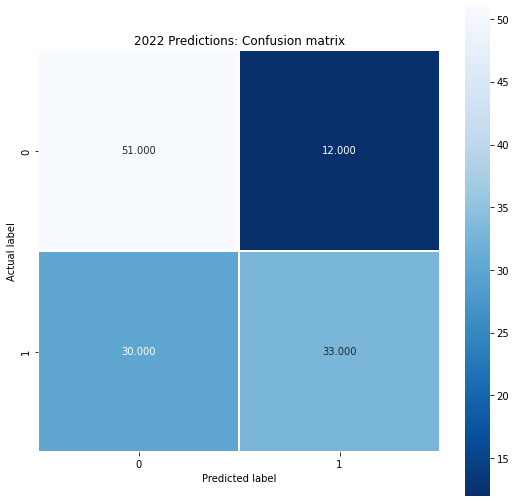

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_test = test_data.select('Result').collect()
preds = predictions.select('prediction').collect()

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('2022 Predictions: Confusion matrix');

Predictions:
Each game is predicted twice, as they are put through the model two times for the model to not be able to predict 

## Round of 64: 

Gonzaga (1211) vs Georgia State (1209):
*   Predicted: Gonzaga, Gonzaga
*   Result: Gonzaga

Boise State (1129) vs Memphis (1272):
*   Predicted: Memphis, **Boise State**
*   Result: Memphis

UCONN (1163) vs New Mexico State (1308):
*   Predicted: UConn, UConn
*   Result: New Mexico State

Arkansas (1116) vs Vermont (1436):
*   Predicted: Arkansas, Arkansas
*   Result: Arkansas

Alabama (1104) vs Notre Dame (1323):
*   Predicted: Alabama, Alabama
*   Result: Notre Dame

Texas Tech (1403) vs Montana State (1286):
*   Predicted: Texas Tech, Texas Tech
*   Result: Texas Tech

Michigan State (1277) vs Davidson (1172):
*   Predicted: **Michigan State**, Davidson
*   Result: Michigan State

Duke (1181) vs CSU Fullerton (1168):
*   Predicted: Duke, Duke
*   Result: Duke

Baylor (1124) vs Norfolk State (1313):
*   Predicted: Baylor, Baylor
*   Result: Baylor

North Carolina (1314) vs Marquette (1266):
*   Predicted: Marquette, **North Carolina**
*   Result: North Carolina

Saint Marry's (1388) vs Indiana (1231):
*   Predicted: Saint Mary's, Saint Mary's
*   Result: Saint Marry's

UCLA (1417) vs Akron (1103):
*   Predicted: UCLA, UCLA
*   Result: UCLA

Texas (1400) vs Virginia Tech (1439):
*   Predicted: Texas, Texas
*   Result: Texas

Purdue (1345) vs Yale (1463):
*   Predicted: Purdue, Purdue
*   Result: Purdue

Murray State (1293) vs San Francisco (1362):
*   Predicted: **Murray State**, San Francisco
*   Result: Murray State

Kentucky (1246) vs Saint Peter's (1389):
*   Predicted: Kentucky, Kentucky
*   Result: Saint Peter's

Arizona (1112) vs  Wright State (1460):
*   Predicted: Arizona, Arizona
*   Result: Arizona

Seton Hall (1371) vs TCU (1395):
*   Predicted: TCU, **Seton Hall**
*   Result: TCU

Houston (1222) vs UAB (1412):
*   Predicted: Houston, Houston
*   Result: Houston

Illinois (1228) vs Chattanooga (1151):
*   Predicted: Illinois, Illinois
*   Result: Illinois

Colorado State (1161) vs Michigan (1276):
*   Predicted: Colorado State, Colorado State
*   Result: Michigan

Tennessee (1397) vs Longwood (1255):
*   Predicted: Tennessee, Tennessee
*   Result: Tennessee

Ohio State (1326) vs Loyola Chicago (1260):
*   Predicted: **Ohio State**, Loyola Chicago
*   Result: Ohio State

Villanova (1437) vs Delaware (1174):
*   Predicted: Villanova, Villanova
*   Result: Villanova

Kansas (1242) vs Texas Southern (1411):
*   Predicted: Kansas, Kansas
*   Result: Kansas

San Diego State (1361) vs Creighton (1166):
*   Predicted: Creighton, **San Diego State**
*   Result: Creighton

Iowa (1234) vs Richmond (1350):
*   Predicted: Iowa, Iowa
*   Result: Richmond

Providence (1344) vs South Dakota State (1355):
*   Predicted: Providence, Providence
*   Result: Providence

LSU (1261) vs Iowa State (1235):
*   Predicted: LSU, LSU
*   Result: Iowa State

Wisconsin (1458) vs Colgate (1159):
*   Predicted: Wisconsin, Wisconsin
*   Result: Wisconsin

USC (1425) vs Miami (1274):
*   Predicted: **USC**, Miami
*   Result: Miami

Auburn (1120) vs Jacksonville State (1240):
*   Predicted: Auburn, Auburn
*   Result: Auburn


## Round of 32:

Gonzaga (1211) vs Memphis (1272):
*   Predicted: Gonzaga, Gonzaga
*   Result: Gonzaga

Arkansas (1116) vs New Mexico State (1308):
*   Predicted: Arkansas, Arkansas
*   Result: Arkansas

Texas Tech (1403) vs Notre Dame (1323):
*   Predicted: Texas Tech, Texas Tech
*   Result: Texas Tech

Michigan State (1277) vs Duke (1181):
*   Predicted: Duke, Duke
*   Result: Duke

Baylor (1124) vs North Carolina (1314):
*   Predicted: Baylor, Baylor
*   Result: North Carolina

Saint Mary's (1388) vs UCLA (1417):
*   Predicted: Saint Mary's, **UCLA**
*   Result: UCLA

Texas (1400) vs Purdue (1345):
*   Predicted: Texas, **Purdue**
*   Result: Purdue

Murray State (1293) vs Saint Peter's (1389):
*   Predicted: Murray State, Murray State
*   Result: Saint Peter's

Arizona (1112) vs TCU (1395):
*   Predicted: Arizona, Arizona
*   Result: Arizona

Houston (1222) vs Illinois (1228):
*   Predicted: Houston, **Illinois**
*   Result: Houston

Tennessee (1397) vs Michigan (1276):
*   Predicted: Tennessee, Tennessee
*   Result: Michigan

Ohio State (1326) vs Villanova (1437):
*   Predicted: Villanova, Villanova
*   Result: Villanova

Kansas (1242) vs Creighton (1166):
*   Predicted: Kansas, Kansas
*   Result: Kansas

Providence (1344) vs Richmond (1350):
*   Predicted: Providence, Providence
*   Result: Providence

Wisconsin (1458) vs Iowa State (1235):
*   Predicted: Wisconsin, Wisconsin
*   Result: Iowa State

Auburn (1120) vs Miami (1274):
*   Predicted: Auburn, Auburn
*   Result: Miami


## Sweet 16:

Gonzaga (1211) vs Arkansas (1116):
*   Predicted: Gonzaga, **Arkansas**
*   Result: Arkansas

Texas Tech (1403) vs Duke (1181):
*   Predicted: Texas Tech, **Duke**
*   Result: Duke

UCLA (1417) vs North Carolina (1314):
*   Predicted: UCLA, UCLA
*   Result: North Carolina

Saint Peter's (1389) vs Purdue (1345):
*   Predicted: Purdue, Purdue
*   Result: Saint Peter's

Arizona (1112) vs Houston (1222):
*   Predicted: Arizona, Arizona
*   Result: Houston

Villanova (1437) vs Michigan (1276):
*   Predicted: Villanova, Villanova
*   Result: Villanova

Kansas (1242) vs Providence (1344):
*   Predicted: **Kansas**, Providence
*   Result: Kansas

Miami (1274) vs Iowa State (1235):
*   Predicted: **Miami**, Iowa State
*   Result: Miami


## Elite 8:

Duke (1181) vs Arkansas (1116):
*   Predicted: **Duke**, Arkansas
*   Result: Duke

Saint Peter's (1389) vs North Carolina (1314):
*   Predicted: North Carolina, North Carolina
*   Result: North Carolina

Villanova (1437) vs Houston (1222):
*   Predicted: **Villanova**, Houston
*   Result: Villanova

Kansas (1242) vs Miami (1274):
*   Predicted: Kansas, Kansas
*   Result: Kansas


## Final Four:

Duke (1181) vs North Carolina (1314):
*   Predicted: Duke, Duke
*   Result: North Carolina

Villanova (1437) vs Kansas (1242):
*   Predicted: Villanova, **Kansas**
*   Result: Kansas


## Championship:

Kansas (1242) vs North Carolina (1314):
*   Predicted: Kansas, Kansas
*   Result: Kansas